# Active-Passive Fluids

## Background

Solve time-dependent Stokes with the director field:
$$\begin{align*} 
    \nabla \cdot v &= 0\\
    \rho\frac{\partial v}{\partial t} &= -\nabla p + \mu \nabla^2 v + \nabla\cdot\sigma\\
    \frac{\partial Q_{ij}}{\partial t} + Q_{ij,k} v_k &= \lambda u_{ij} + [Q,w]_{ij} + \frac{1}{\gamma} H_{ij}
\end{align*}$$
where 
$$\begin{align*} 
    \sigma_{ij} &= -\lambda H_{ij} + Q_{ik} H_{kj} - H_{ik}Q_{kj} + \alpha Q_{ij}\\
    u_{ij} &= \frac{1}{2} \left( v_{i,j} + v_{j,i} \right)\\
    w_{ij} &= \frac{1}{2} \left( v_{i,j} - v_{j,i} \right)
\end{align*}$$

## FEM Simulation using FEniCS

Requires FEniCS version 2019.1.0

In [1]:
from dolfin import *
from mshr import *
import ufl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from tqdm import tqdm

In [21]:
# run parameters
Tf = 10.
dt = Constant(0.1)

# mesh generation
R = 2.0;
N = 32;
domain = Circle(Point(0, 0), R)
mesh = generate_mesh(domain, N)

# define function spaces for the velocities and pressure
el_deg = 2
V = FunctionSpace(mesh, "CG", el_deg); VE = V.ufl_element()
V2D = VectorFunctionSpace(mesh, "CG", el_deg, 2)
P = FunctionSpace(mesh, "CG", el_deg-1); PE = P.ufl_element()
V_tens = TensorFunctionSpace(mesh, "CG", el_deg); V_tensE = V_tens.ufl_element()
VQ = FunctionSpace(mesh, "CG", el_deg-1); VQE = VQ.ufl_element()
# create mixed function space for the corrector step
ME = MixedElement([VE,VE,PE,VQE,VQE])
M = FunctionSpace(mesh, ME)

# create unknown functions and test functions
u = Function(M)
(vx,vy,p,q1,q2) = split(u)
u_ = TestFunction(M)
(vx_,vy_,p_,q1_,q2_) = split(u_)
u0 = Function(M) # previous time-step
(vx0,vy0,p0,q10,q20) = split(u0)

# velocity vector
v = as_tensor([vx,vy])
v_ = as_tensor([vx_,vy_])
v0 = as_tensor([vx0,vy0])

# Q tensor
Q = as_tensor([
    [q1, q2],
    [q2, -q1]
])
Q_ = as_tensor([
    [q1_, q2_],
    [q2_, -q1_]
])
Q0 = as_tensor([
    [q10, q20],
    [q20, -q10]
])

# spatial coordinates
x_mesh = SpatialCoordinate(mesh)
r = sqrt(x_mesh[0]*x_mesh[0] + x_mesh[1]*x_mesh[1])
theta = ufl.atan_2(x_mesh[1],x_mesh[0])
eb_r = as_tensor([x_mesh[0]/r, x_mesh[1]/r])
eb_theta = as_tensor([-x_mesh[1]/r, x_mesh[0]/r])

# mesh normal
n = FacetNormal(mesh) # could use x_mesh, but maybe more accurate this way geometrically
# n = CellNormal(mesh) # could use x_mesh, but maybe more accurate this way geometrically

# define boundaries
def boundary(x, on_boundary):
    return on_boundary
def origin(x,on_boundary):
    return near(x[0], 0.) and near(x[1], 0.)

# boundary conditions
v_bc_0 = Expression('-x[1]', degree=2)
v_bc_1 = Expression('x[0]', degree=2)
q1_bc = Expression('x[1]*x[1]/(x[0]*x[0]+x[1]*x[1])-1./2.', degree=2)
q2_bc = Expression('-x[0]*x[1]/(x[0]*x[0]+x[1]*x[1])', degree=2)
# bc1 = DirichletBC(M.sub(0), v_bc_0, boundary) # \eb_\theta \cdot \eb_x
# bc2 = DirichletBC(M.sub(1), v_bc_1, boundary) # \eb_\theta \cdot \eb_y
bc1 = DirichletBC(M.sub(0), Constant(0.), boundary) # v_x = 0
bc2 = DirichletBC(M.sub(1), Constant(0.), boundary) # v_y = 0
bc_p_datum = DirichletBC(M.sub(2), Constant(0.), origin, 'pointwise')
bc3 = DirichletBC(M.sub(3), q1_bc, boundary)
bc4 = DirichletBC(M.sub(4), q2_bc, boundary)
bcs = [bc1, bc2, bc_p_datum, bc3, bc4]

'''
Weak forms
'''
# indicies for summation convention
i, j, k, l = ufl.indices(4)

# active force
# C1 = Constant(1.);
# C2 = Constant(1.);
# L = Constant(0.);
# lam = Constant(0.);
# gamma = Constant(1.);
# alpha = Constant(1.);
C1 = Constant(4e4);
C2 = Constant(4e4);
L = Constant(1.);
lam = Constant(0.1);
gamma = Constant(10.);
alpha = Constant(1.);
# f_active = C*Q[i,j]*Q[j,i]*(Q[k,l]*Q[l,k] - 1) + L/Constant(2.)*Q[i,j].dx(k)*Q[i,j].dx(k)

# compute H_{ij} = \delta f / \delta Q_{ij}
f_active = C1*Q[i,j]*Q[j,k]*Q[k,l]*Q[l,i] - C2*Q[i,j]*Q[j,i] #+ L*Constant(1./2.)*Q[i,j].dx(k)*Q[i,j].dx(k)
dq = TrialFunction(VQ)
h1 = derivative(f_active, q1, dq); h2 = derivative(f_active, q2, dq)
h1 = ufl.replace(h1, {dq: Constant(1.)}); h2 = ufl.replace(h2, {dq: Constant(1.)})
H = as_tensor([
    [h1, h2],
    [h2, -h1]
])

# active stress tensor
sigma_nematic = as_tensor(
    -lam*H[i,j] + Q[i,k]*H[k,j] - H[i,k]*Q[k,j] + alpha*Q[i,j],
    (i,j)
)

# Stokes Equation
# f = Constant((0.0, 0.0))
G = inner(grad(v), grad(v_))*dx + div(v_)*p*dx + p_*div(v)*dx - Constant(1.)*v_[i].dx(j)*sigma_nematic[i,j] * dx
# G += inner(f, v_)*dx

# Q equation
v_sym = as_tensor(
    Constant(1./2.)*(v[j].dx(i) + v[i].dx(j)),
    (i,j)
)
v_anti = as_tensor(
    Constant(1./2.)*(v[j].dx(i) - v[i].dx(j)),
    (i,j)
)
G_ss = G + (-Constant(0.)*(Q[i,j]-Q0[i,j])/dt + lam*v_sym[i,j] + Q[i,k]*v_anti[k,j] - v_anti[i,k]*Q[k,j] + H[i,j]/gamma)*Q_[i,j] * dx
G += (-Constant(1.)*(Q[i,j]-Q0[i,j]) + dt*( lam*v_sym[i,j] + Q[i,k]*v_anti[k,j] - v_anti[i,k]*Q[k,j] + H[i,j]/gamma ))*Q_[i,j] * dx
# -Constant(0.)*(Q[i,j]-Q0[i,j])/dt + 

# solve(G==0, u, bcs)

In [22]:
# steady-state solution
set_log_level(20)
solve(G_ss==0, u, bcs)
u0.assign(u)

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 4.344e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 1.677e+03 (tol = 1.000e-10) r (rel) = 3.860e-01 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.370e+00 (tol = 1.000e-10) r (rel) = 3.153e-04 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 5.421e-05 (tol = 1.000e-10) r (rel) = 1.248e-08 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 2.865e-10 (tol = 1.000e-10) r (rel) = 6.595e-14 (tol = 1.000e-09)
    Newton solver finished in 4 iterations and 4 linear solver iterations.


In [23]:
'''
initial conditions
'''
# "random" initialization... doesn't work at the moment
# np.random.seed(314)
# q1_dofs = M.sub(3).dofmap().dofs()
# q1_init = np.random.rand(len(q1_dofs)) - 0.5 # needs to be in the interval [-1/2,1/2]
# u.vector()[q1_dofs] = q1_init

# q1_init = Expression('cos(x[0]*cos(x[1]))/2.1', element=VQE)
q1_init = Expression('sin(x[0]*sin(x[1]))/2.1', element=VQE)
q1_init = interpolate(q1_init,VQ)
assign(u0.sub(3),q1_init)

'''
suppress output 

CRITICAL  = 50, // errors that may lead to data corruption and suchlike
ERROR     = 40, // things that go boom
WARNING   = 30, // things that may go boom later
INFO      = 20, // information of general interest
PROGRESS  = 16, // what's happening (broadly)
TRACE     = 13, // what's happening (in detail)
DBG       = 10  // sundry
'''
set_log_level(20)

'''
Time Loop
'''
numt = round(Tf/dt.values()[0])
numt = 1
for _ in tqdm(range(0,numt)):
    # solve time-step
    solve(G==0, u, bcs)
    # solver_parameters={"linear_solver": "lu"},
    
    # assign current time-step to previous
    u0.assign(u)

  0%|          | 0/1 [00:00<?, ?it/s]

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.419e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

    Newton iteration 1: r (abs) = 7.051e-04 (tol = 1.000e-10) r (rel) = 4.970e-03 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.139e-10 (tol = 1.000e-10) r (rel) = 8.027e-10 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.


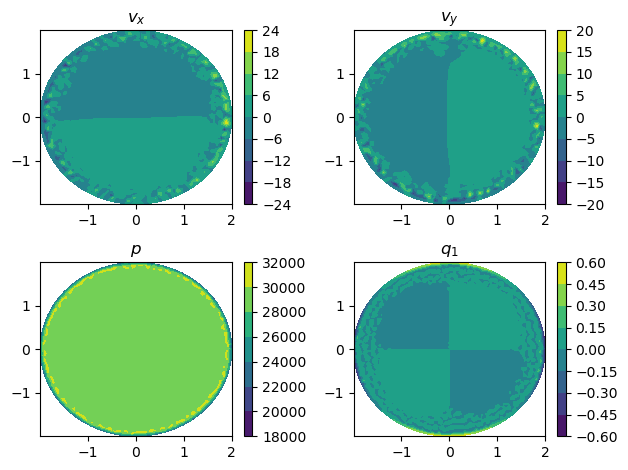

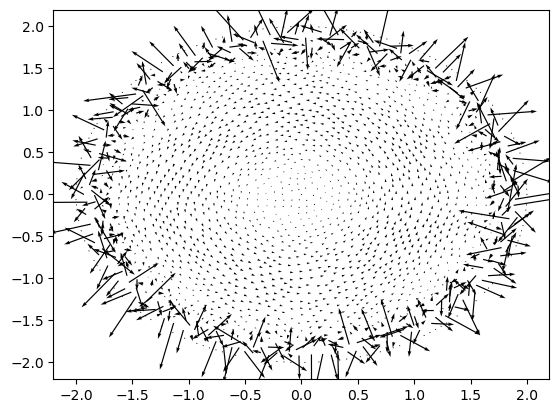

In [24]:
# %matplotlib inline

XY = mesh.coordinates()
X = XY[:,0]; Y = XY[:,1]

fig, axes = plt.subplots(nrows=2, ncols=2)
titles = ["$v_x$", "$v_y$", "$p$", "$q_1$"]
for i,row in enumerate(axes):
    for j,ax in enumerate(row):
        ij_flat = i*2 + j
        Z = np.array([u.sub(ij_flat)(x,y) for x,y in zip(X,Y)])
        pi_plot = ax.tricontourf(X,Y,Z)
        plt.colorbar(pi_plot,ax=ax)
        ax.set_title(titles[ij_flat])

fig.tight_layout()

fig,ax = plt.subplots()
v_proj = project(v,V2D)
v_proj = np.array([v_proj(x,y) for x,y in zip(X,Y)])
ax.quiver(X, Y, v_proj[:,0], v_proj[:,1])

# # director plot
# n1 = ufl.sqrt(abs(q1) + 1/2);
# n2 = q2/n1;
# # n2 = ufl.sqrt(-abs(q1) + 1/2); # *ufl.sign(q2)
# # n2 = ufl.sqrt(1 - n1*n1);
# nvec = as_tensor([n1,n2])
# nvec = project(nvec,V2D)
# fig,ax = plt.subplots()
# nvec = np.array([nvec(x,y) for x,y in zip(X,Y)])
# ax.quiver(X, Y, nvec[:,0], nvec[:,1])

                                Object cannot be plotted directly, projecting to piecewise linears.


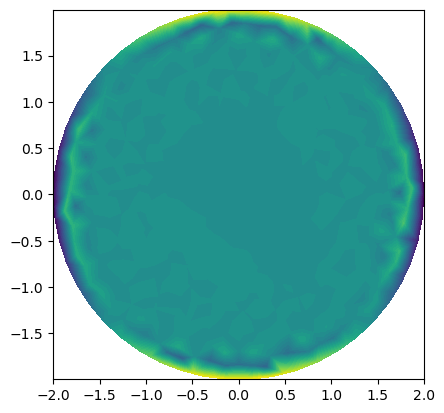

In [337]:
plot(q1)